## Import needed packages

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

## Hyperparameter


In [3]:
config = {
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "batch_size" : 64,
    "learning_rate" : 0.01 ,
    "epochs":5,
}

## Dataloader

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=True)

## Visualize


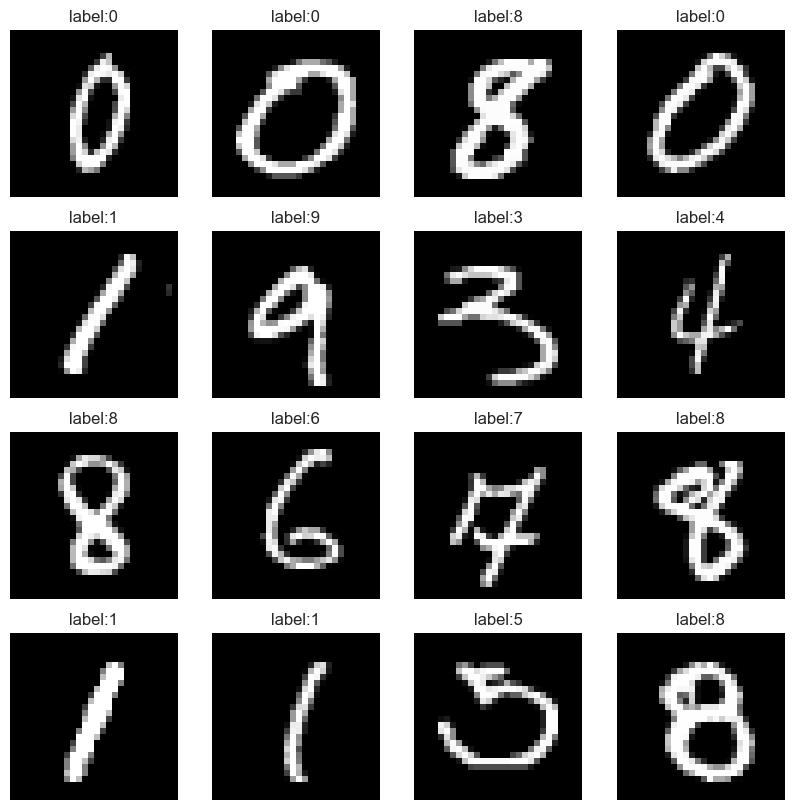

In [5]:
examples = iter(train_loader)
images, labels = next(examples)

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i][0], cmap='gray')
    # plt.title(f"Label: {labels[i].item()}")
    plt.title(f"label:{labels[i]}")
    plt.axis('off')
plt.show()


## Model


In [7]:
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),                                 # 展平 28x28 图像
            nn.Linear(28*28, 512),                        # 输入层
            nn.BatchNorm1d(512),                          # 批归一化
            nn.LeakyReLU(0.1),                            # LeakyReLU 防止死神经元
            nn.Dropout(0.3),                              # Dropout 防止过拟合

            nn.Linear(512, 256),                          # 中间层1
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(256, 128),                          # 中间层2
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(128, 10),                           # 输出层
        )

    def forward(self, x):
        return self.model(x)

model = SimpleNN().to(config["device"])


In [9]:
from torchsummary import summary

summary(model, input_size=(28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
       BatchNorm1d-3                  [-1, 512]           1,024
         LeakyReLU-4                  [-1, 512]               0
           Dropout-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
       BatchNorm1d-7                  [-1, 256]             512
         LeakyReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                  [-1, 128]          32,896
      BatchNorm1d-11                  [-1, 128]             256
        LeakyReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   

## Loss Function and Optimizer

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

NameError: name 'model' is not defined

## Trainig loop

In [7]:
from tqdm import tqdm

best_acc = 0.0  # 当前最优准确率

for epoch in range(config["epochs"]):
    total_loss = 0.0
    model.train()

    print(f"\n🔄 Epoch {epoch+1}/{config['epochs']}")
    train_bar = tqdm(train_loader, desc="Training", dynamic_ncols=True, leave=False)

    for images, labels in train_bar:
        images, labels = images.to(config["device"]), labels.to(config["device"])

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1} finished. Average Loss: {avg_loss:.4f}")

    # =============== 验证集评估（可用 test_loader） ===============
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(config["device"]), labels.to(config["device"])
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    print(f"📊 Test Accuracy after Epoch {epoch+1}: {acc*100:.2f}%")

    # =============== 保存最好的模型 ===============
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_model.pth")
        print("💾 Saved new best model!")

print(f"\n🏁 Training done. Best Accuracy: {best_acc*100:.2f}%")



🔄 Epoch 1/5


✅ Epoch 1 finished. Average Loss: 0.2891
📊 Test Accuracy after Epoch 1: 95.56%
💾 Saved new best model!

🔄 Epoch 2/5


✅ Epoch 2 finished. Average Loss: 0.1708
📊 Test Accuracy after Epoch 2: 97.04%
💾 Saved new best model!

🔄 Epoch 3/5


✅ Epoch 3 finished. Average Loss: 0.1402
📊 Test Accuracy after Epoch 3: 97.33%
💾 Saved new best model!

🔄 Epoch 4/5


✅ Epoch 4 finished. Average Loss: 0.1244
📊 Test Accuracy after Epoch 4: 97.75%
💾 Saved new best model!

🔄 Epoch 5/5


✅ Epoch 5 finished. Average Loss: 0.1145
📊 Test Accuracy after Epoch 5: 97.77%
💾 Saved new best model!

🏁 Training done. Best Accuracy: 97.77%


## Testing

In [8]:
with torch.no_grad():
    total = 0
    correct = 0
    model.eval()
    for images, labels in tqdm(test_loader, desc="Testing", dynamic_ncols=True, leave=False):
        images, labels = images.to(config["device"]),labels.to(config["device"])
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 97.77%


## Saving Model

In [9]:
torch.save(model.state_dict(), "model.pth")

## Load Model and Predict

In [10]:
model.load_state_dict(torch.load("model.pth"))
model.eval()

images, labels = next(iter(test_loader))
images, labels = images.to(config["device"]),labels.to(config["device"])
outputs = model(images)
_, predicted = torch.max(outputs.data, 1)
print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 97.77%


## Visualize

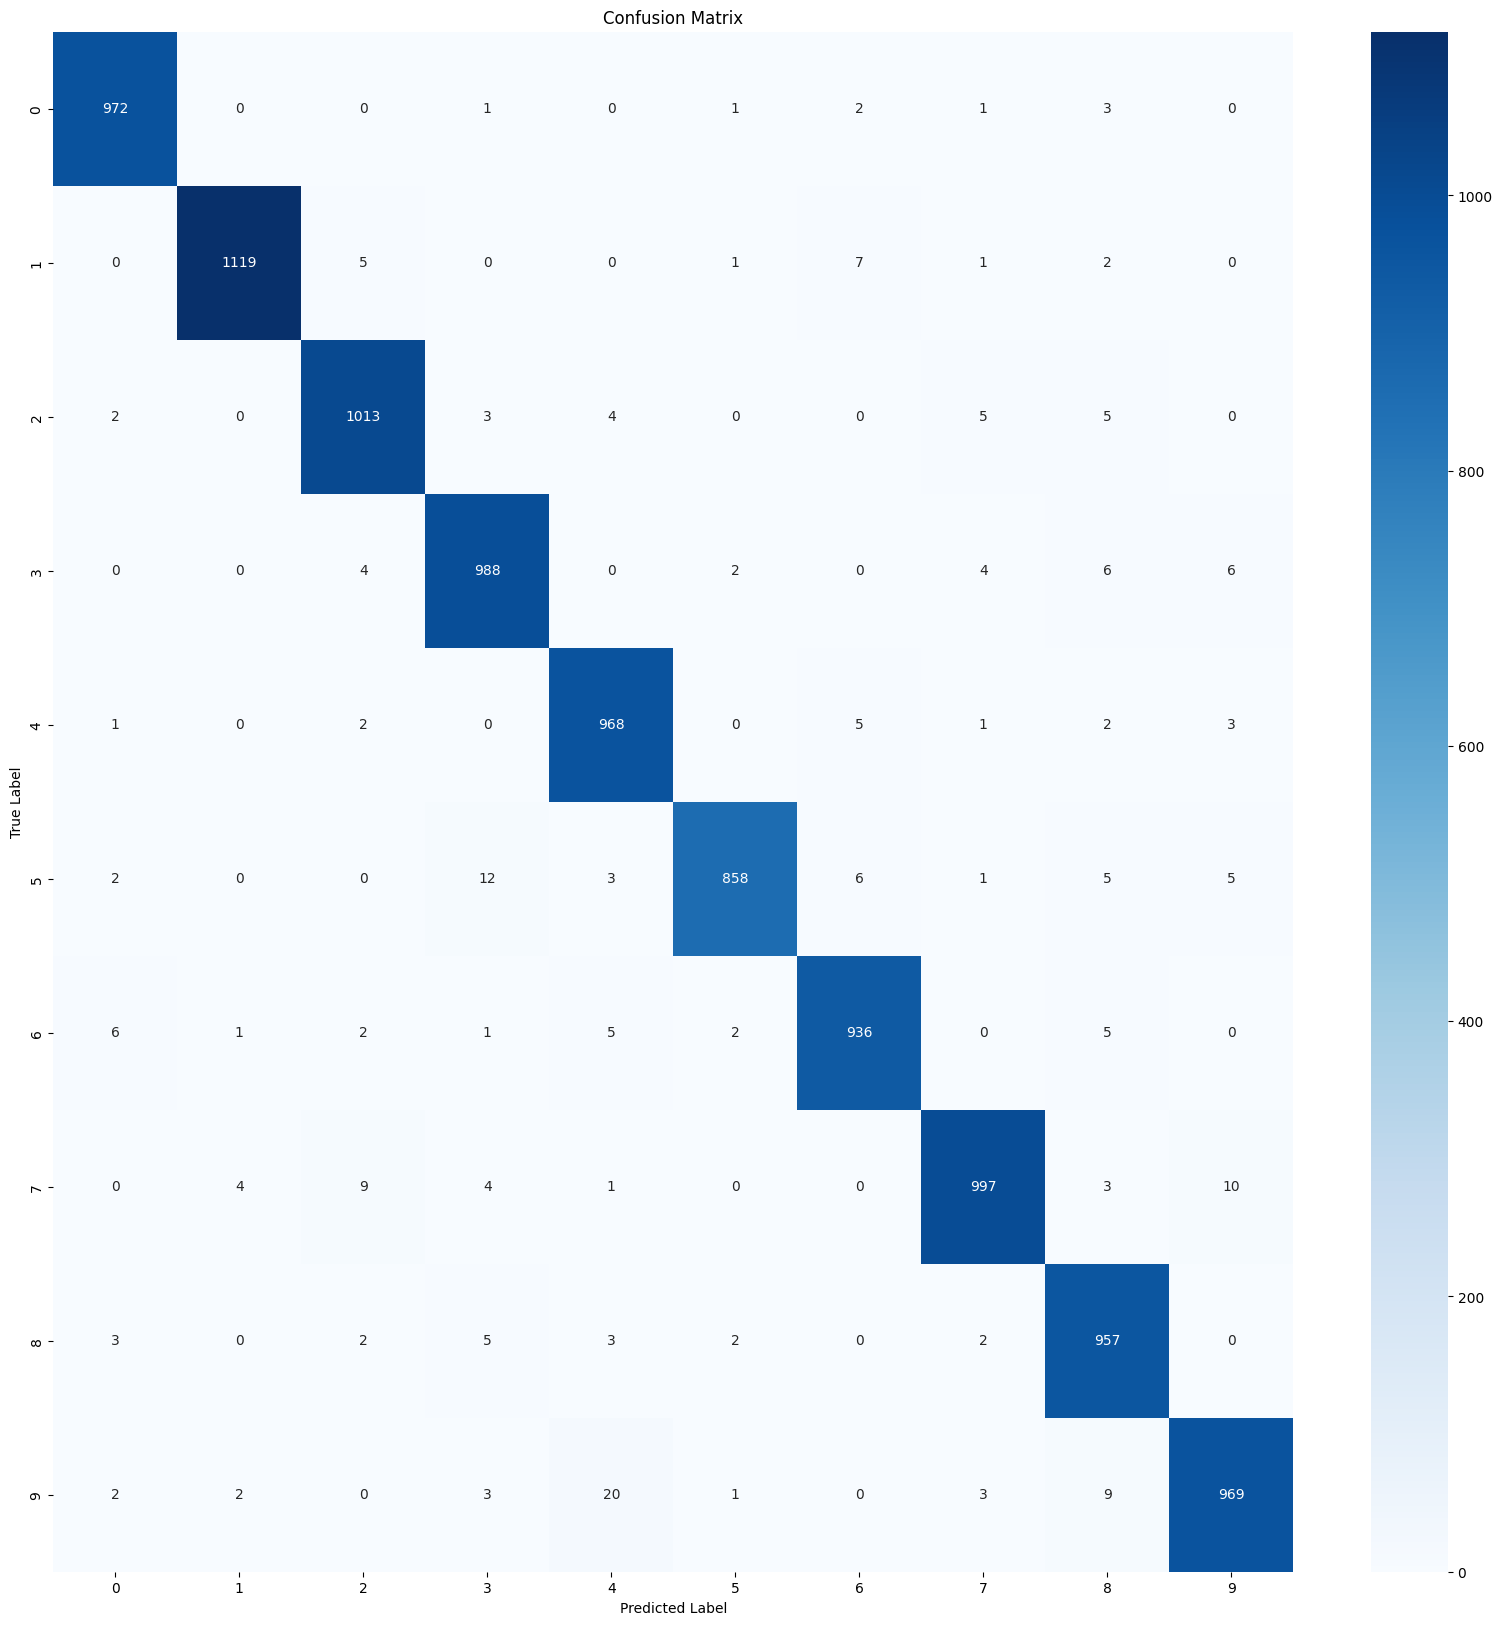

In [11]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(config["device"]), labels.to(config["device"])
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# calculate
cm = confusion_matrix(all_labels, all_preds)

# Visualize
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
